# Soil Organic Carbon Model

Maria Oros
JH Lab 2024

## Import ML packages

In [ ]:
import scipy
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import netcdf

from sklearn import metrics
  # Import all metrics at once
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import joblib  # Optional import
import statsmodels.api as sm  # Optional import
import itertools  # Optional import
import time  # Optional import

from xgboost import XGBRegressor

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             accuracy_score)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import seaborn as sns

%matplotlib inline

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns
from sklearn.metrics import r2_score

## Data input

The data input consist of ~40K soul organic carbon obrservations across the CONUS, spaning from 1985 to 2002 extracted from NEON. Each observation in time and location is obtained in 6 soil depths 5,10,15,30,100,200cm. Later 15 soil dynamic properties related to such locations and time were collected from GEE. The process of data extraction was automated using GEE API in the Cyber infraestructure that is about to be publish as part of this work.

In [ ]:
data = pd.read_csv(genral_path+'final_conus_v2.csv')

### Pre procesing

Soil organic carbon observations that are valid, belong to the range 0-100

In [ ]:
target='soil_organic_carbon'
soil_armonized_complete=data[data[target].between(0,100)]
soil_armonized_complete=soil_armonized_complete[~soil_armonized_complete['clay_mean'].isna()]

grouped = soil_armonized_complete.groupby(['latitude', 'longitude', 'depth_cm'])

# Select the first row of each group
data = grouped.first().reset_index()


print(data.columns)

Index(['latitude', 'longitude', 'depth_cm', 'Unnamed: 0', 'soil_id', 'year',
       'soil_organic_carbon', 'land_use', 'land_cover', 'land_cover_class',
       'land_use_class', 'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean', 'label'],
      dtype='object')


In [ ]:
data.shape

(37992, 26)

In [ ]:
key_variables =['year',
                'soil_organic_carbon',
                #'depth_cm',
                'total_precipitation',
                'min_temperature',
                'mean_temperature',
                'max_temperature',
                'dem',
                'slope',
                'aspect',
                'hillshade',
                'bd_mean',
                'clay_mean',
                'om_mean',
                'ph_mean',
                'sand_mean',
                'silt_mean'
                #,'land_use', 'land_cover'
                            ]

key_variables.sort()
data[key_variables].describe()

,aspect,bd_mean,clay_mean,dem,hillshade,max_temperature,mean_temperature,min_temperature,om_mean,ph_mean,sand_mean,silt_mean,slope,soil_organic_carbon,total_precipitation,year
count,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000
mean,174.740901,1.378652,21.017026,508.032610,180.133791,17.972214,23.296360,5.324146,-0.135957,6.047998,31.987844,42.511539,4.369680,1.496149,1078.911728,1997.062434
std,103.047888,0.134064,11.893299,581.363783,15.858041,4.067408,7.861087,3.963573,0.541414,1.020802,22.702238,17.642474,5.799869,3.579501,552.144559,9.098066
min,0.000000,0.510000,0.500000,-2.063870,62.000000,2.382658,-8.067233,-12.104932,-4.965000,2.485503,0.838867,0.500000,0.000000,0.000020,26.470000,1985.000000
25%,86.196107,1.326348,12.354945,210.603302,177.000000,15.636130,18.429397,2.437178,-0.541625,5.216519,13.632780,29.598166,0.662710,0.255099,775.000000,1990.000000
50%,174.036351,1.388480,18.894739,301.894043,180.000000,18.868685,25.146630,6.469945,-0.107041,5.876823,25.748042,42.750610,2.049632,0.697981,1051.470000,1994.000000
75%,262.918676,1.447839,27.412397,460.408691,184.000000,20.228767,27.874795,7.553562,0.233735,6.698348,46.800392,57.094539,5.636532,1.572189,1269.910000,2004.000000
max,359.929312,1.942642,74.155243,3883.314453,255.000000,31.150219,48.934630,19.751342,1.943514,9.534649,99.500000,93.468651,46.889959,67.788097,4887.200000,2021.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37992 entries, 0 to 37991
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitude             37992 non-null  float64
 1   longitude            37992 non-null  float64
 2   depth_cm             37992 non-null  int64  
 3   Unnamed: 0           37992 non-null  int64  
 4   soil_id              37992 non-null  object 
 5   year                 37992 non-null  int64  
 6   soil_organic_carbon  37992 non-null  float64
 7   land_use             37992 non-null  float64
 8   land_cover           37992 non-null  float64
 9   land_cover_class     37992 non-null  object 
 10  land_use_class       37992 non-null  object 
 11  total_precipitation  37992 non-null  float64
 12  min_temperature      37992 non-null  float64
 13  mean_temperature     37992 non-null  float64
 14  max_temperature      37992 non-null  float64
 15  dem                  37992 non-null 

In [ ]:
data['land_use'] = data['land_use'].astype('category')
data['land_cover'] = data['land_cover'].astype('category')

### Train and Test Sample

In [ ]:
class_counts = data['soil_id'].value_counts()

# Filter classes with at least two instances
filtered_data = data[data['soil_id'].isin(class_counts[class_counts > 1].index)]
filtered_data = filtered_data[(filtered_data['soil_organic_carbon'].between(0,100)) & (filtered_data['year']<2020)]
len(filtered_data)

37917

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Sample data
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

# Split the data
train_index, test_index = next(splitter.split(data, groups=data['soil_id']))

train_data = data.iloc[train_index]
test_data = data.iloc[test_index]

# Display results
print("Train Data:",len(set(train_data['soil_id'].values)))
print("\nTest Data:", len(set(test_data['soil_id'].values)))


Train Data: 5493

Test Data: 1374


In [ ]:
for x in train_data['soil_id'].values:
  if x in test_data['soil_id'].values:
    print(x)

In [ ]:
for x in test_data['soil_id'].values:
  if x in train_data['soil_id'].values:
    print(x)

In [ ]:
covariates=['depth_cm', 'land_use', 'land_cover',
        'total_precipitation', 'mean_temperature',#'min_temperature','max_temperature',
         'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean',
        'sand_mean'#,'silt_mean' because its correlated with sand
        ]

X_train = train_data[covariates]
Y_train = train_data['soil_organic_carbon'].values
X_test = test_data[covariates]
Y_test = test_data['soil_organic_carbon'].values


<Axes: xlabel='year', ylabel='soil_organic_carbon'>

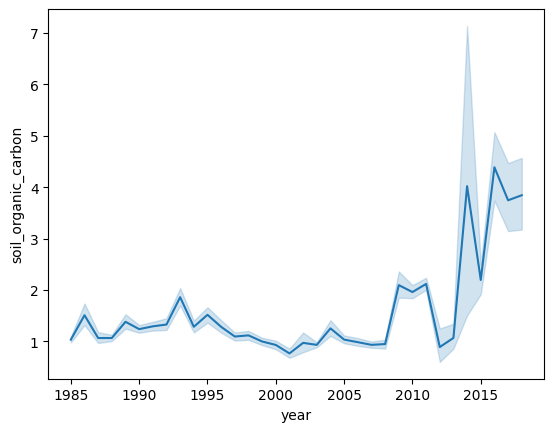

In [ ]:
sns.lineplot(data=filtered_data, x="year", y="soil_organic_carbon"#, hue="version"
)

### Data Distribution

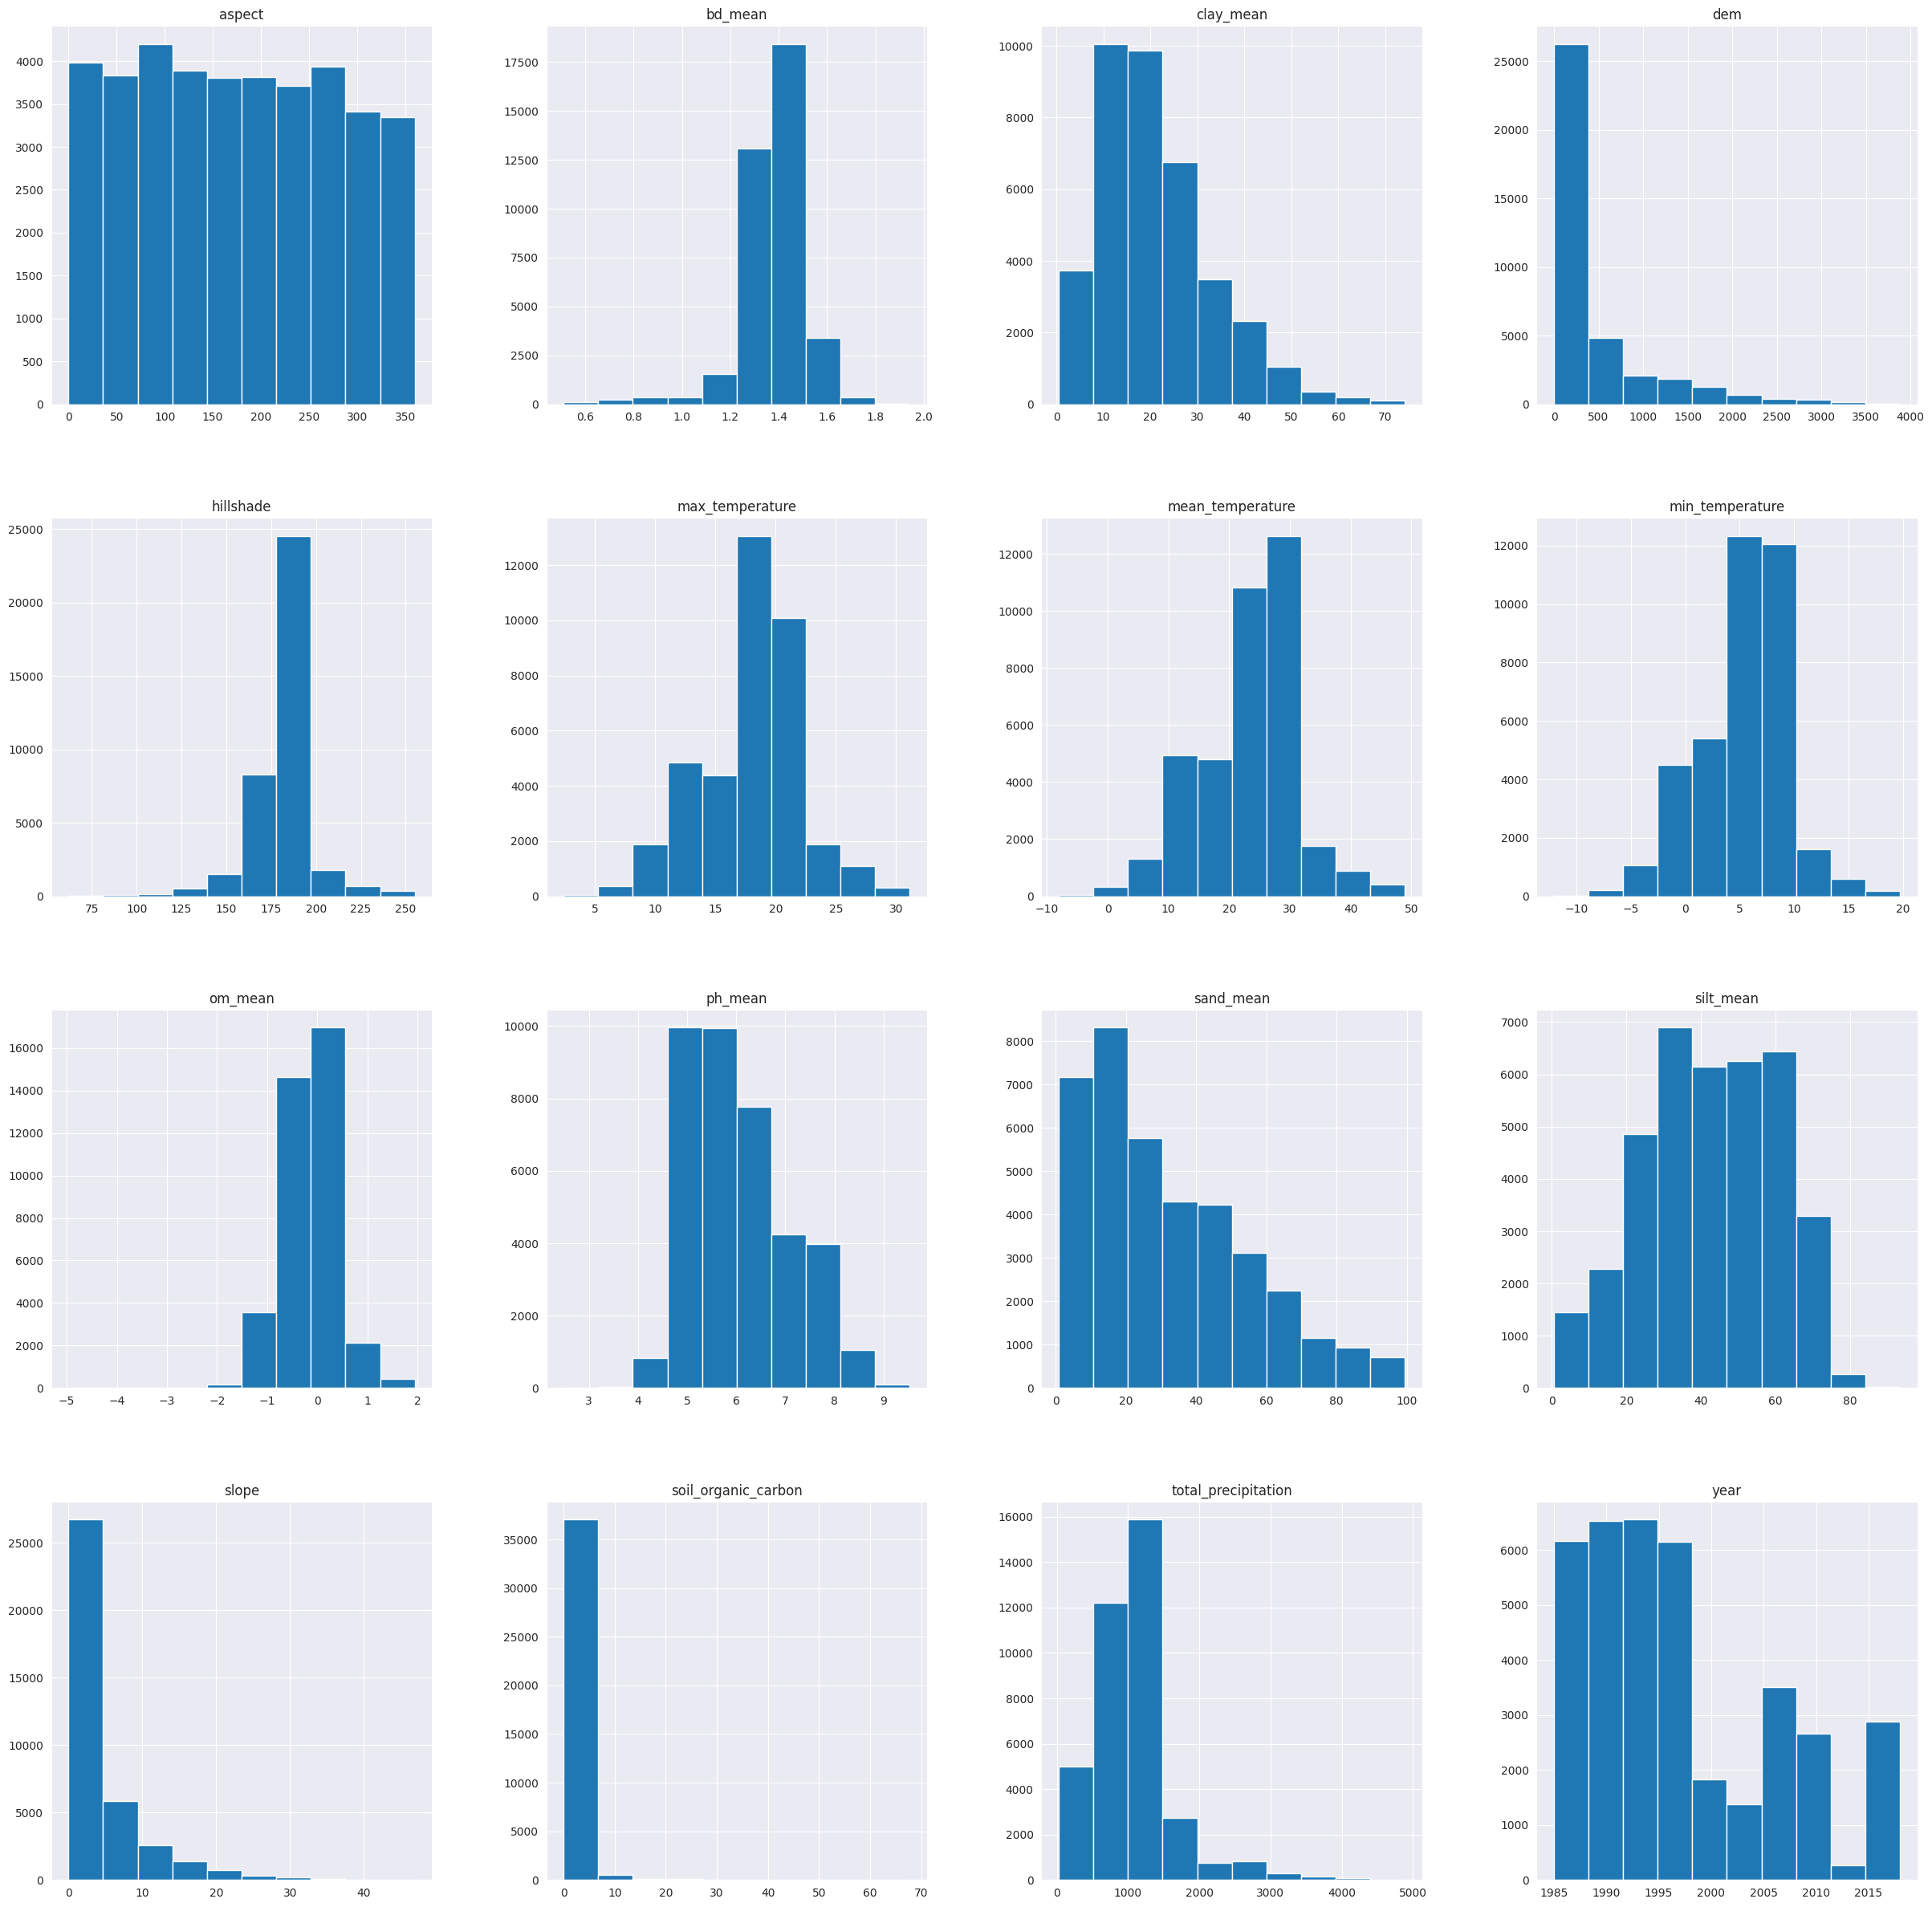

In [ ]:
# Plot histograms for each variable
sns.set_style('darkgrid')
filtered_data[key_variables].hist(figsize=(30,30))
plt.show()

In [ ]:
filtered_data[key_variables].describe()

,aspect,bd_mean,clay_mean,dem,hillshade,max_temperature,mean_temperature,min_temperature,om_mean,ph_mean,sand_mean,silt_mean,slope,soil_organic_carbon,total_precipitation,year
count,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000
mean,174.730416,1.378651,21.018801,507.771393,180.132782,17.972564,23.297314,5.324750,-0.135958,6.047724,31.981373,42.518036,4.368068,1.494076,1079.018150,1997.064205
std,103.050586,0.134047,11.892544,581.147646,15.850632,4.067472,7.861233,3.963565,0.541300,1.020577,22.701033,17.640260,5.798247,3.571980,552.159502,9.098412
min,0.000000,0.510000,0.500000,-2.063870,62.000000,2.382658,-8.067233,-12.104932,-4.965000,2.485503,0.838867,0.500000,0.000000,0.000020,26.470000,1985.000000
25%,86.196107,1.326348,12.357837,210.573990,177.000000,15.636130,18.429781,2.437178,-0.541575,5.216472,13.630648,29.606030,0.662375,0.255099,775.140000,1990.000000
50%,174.012240,1.388478,18.899022,301.859436,180.000000,18.868740,25.146630,6.471342,-0.106945,5.876685,25.741095,42.757812,2.049380,0.698054,1051.470000,1994.000000
75%,262.918676,1.447791,27.415954,460.169006,184.000000,20.228767,27.874904,7.553562,0.233717,6.697277,46.800392,57.104942,5.635239,1.571914,1269.910000,2004.000000
max,359.929312,1.942642,74.155243,3883.314453,255.000000,31.150219,48.934630,19.751342,1.943514,9.534649,99.500000,93.468651,46.889959,67.788097,4887.200000,2021.000000


From the matrix of correlations we observe that Organic matter is the more correlated variable with soil organic carbon, followed by bulk density. Correlation between other variables as min temperature and max temperature could affect the model performance because of a multicolinearity issue, so for such reason, some variables were removed frm the modeling side in the modelling steps.

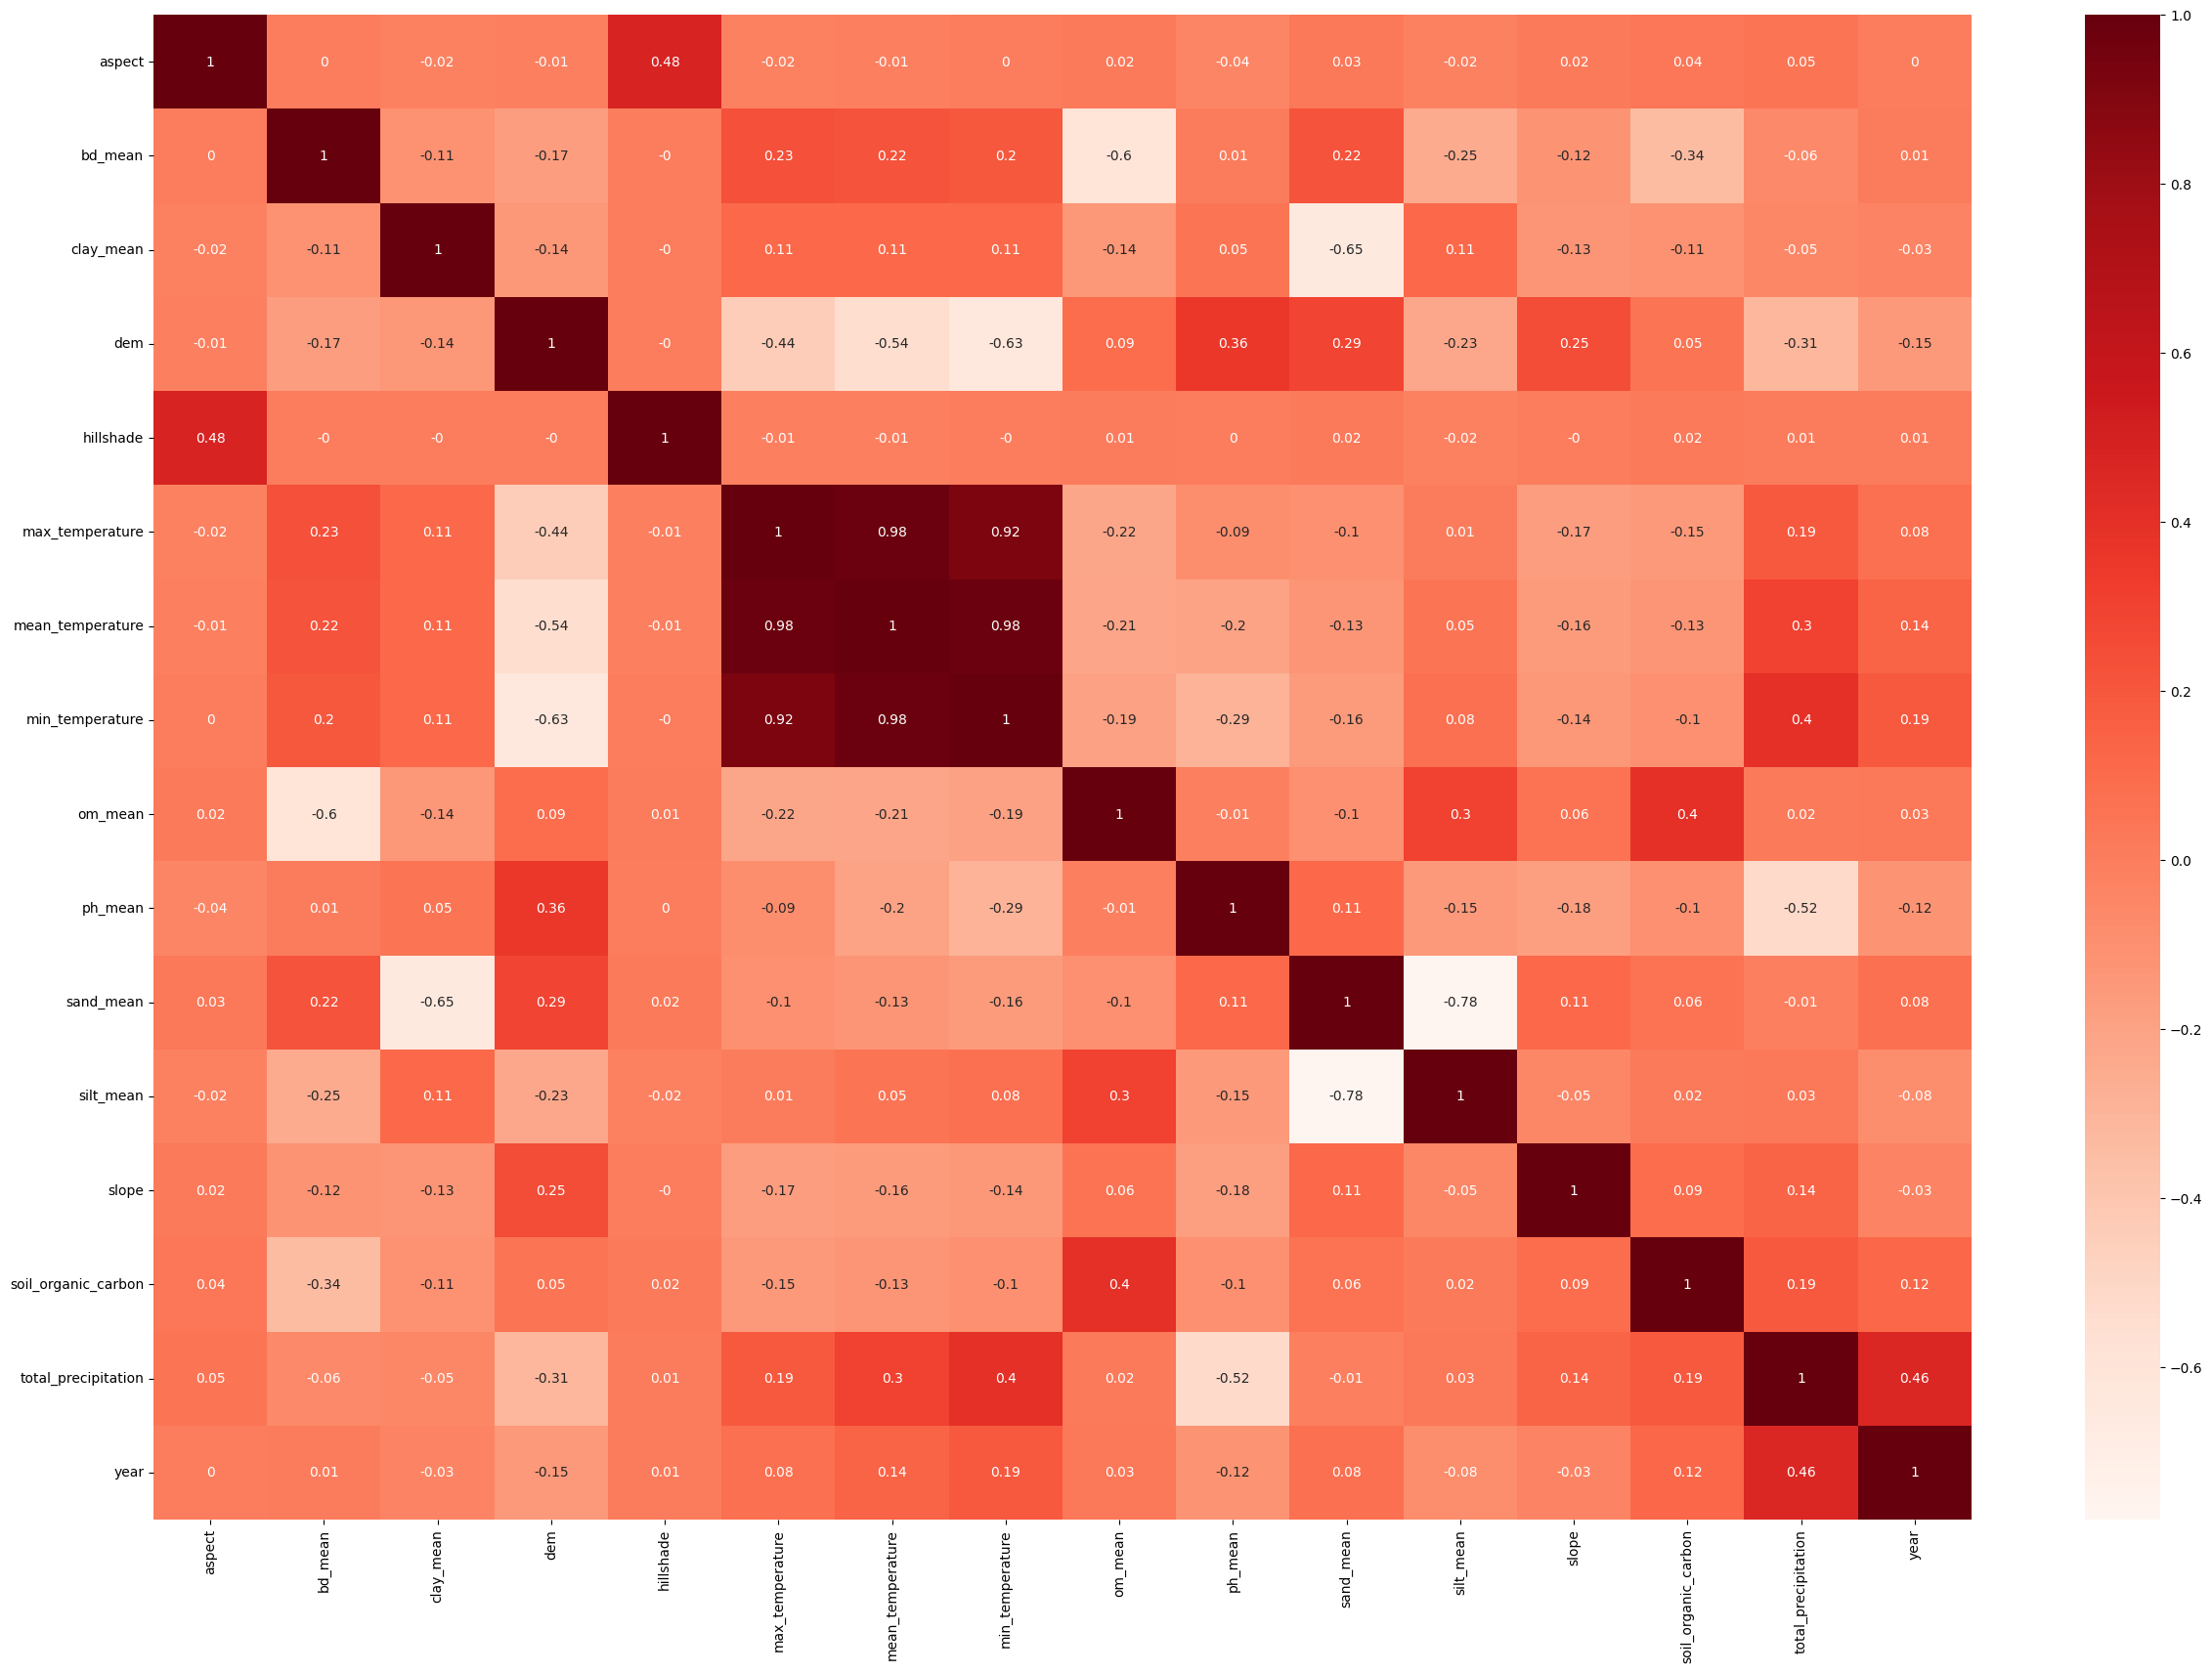

In [ ]:
plt.figure(figsize=(30,20))
cor = filtered_data[key_variables].corr().round(2)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable, bulk density and organic matter the more correlated with soil organic carbon.
cor_target = abs(cor["soil_organic_carbon"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

,soil_organic_carbon
bd_mean,0.34
om_mean,0.40
soil_organic_carbon,1.00


## Modeling Soil Organic Carbon

In [ ]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

#### Comparing models on predicting SOC

In [ ]:
import xgboost as xgb# import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define models to train
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Random Forest', RandomForestRegressor()))
#models.append(('SVR', SVR()))
models.append(('XGBoost', xgb.XGBRegressor(enable_categorical=True)))

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Define models to train
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Random Forest', RandomForestRegressor()))
#models.append(('SVR', SVR()))
models.append(('XGBoost', xgb.XGBRegressor(enable_categorical=True)))


results = {
    'Model': [],
    'MSE': [],
    'R2': []
}

for name, model in models:
  if name=='XGBoost':
    X_train_xgb = pd.get_dummies(X_train, columns=['land_use', 'land_cover'])
    model = XGBRegressor(enable_categorical=True)
    model.fit(X_train, Y_train)
  else:
    model.fit(X_train, Y_train)

  predictions = model.predict(X_test)
  mse = mean_squared_error(Y_test, predictions)
  r2 = r2_score(Y_test, predictions)

  results['Model'].append(name)
  results['MSE'].append(mse)
  results['R2'].append(r2)

results_df = pd.DataFrame(results)

print(results_df)

               Model        MSE        R2
0  Linear Regression  11.008465  0.213794
1      Random Forest   8.960641  0.360046
2            XGBoost   9.856389  0.296074


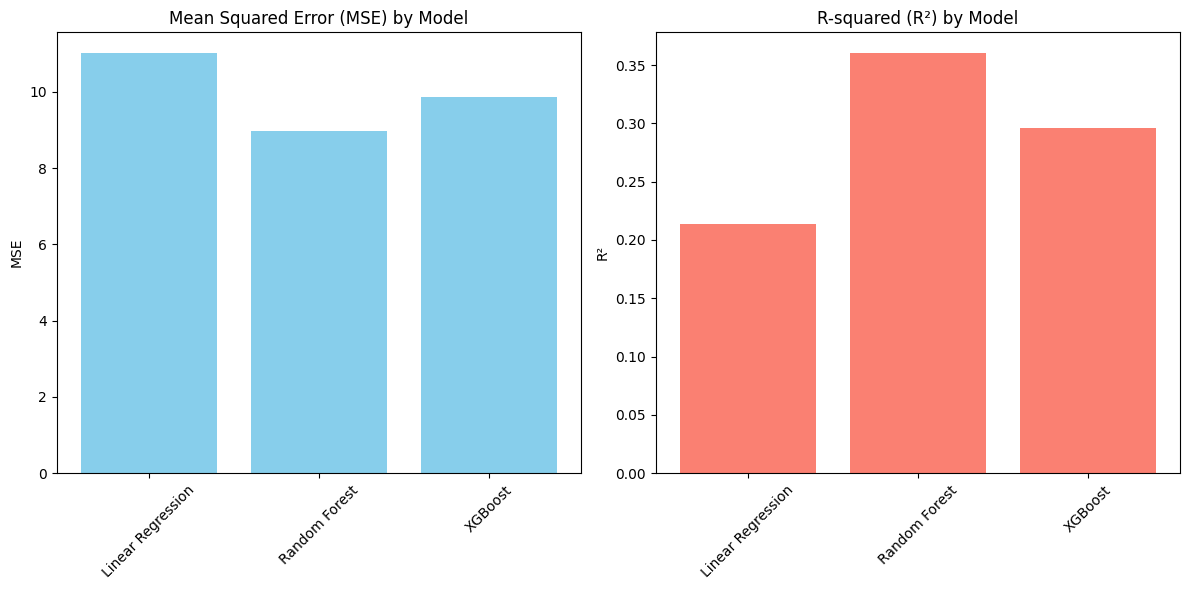

In [ ]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'results_df'
# Set the figure size
plt.figure(figsize=(12, 6))

# Plotting MSE
plt.subplot(1, 2, 1)
plt.bar(results_df['Model'], results_df['MSE'], color='skyblue')
plt.title('Mean Squared Error (MSE) by Model')
plt.ylabel('MSE')
plt.xticks(rotation=45)

# Plotting R²
plt.subplot(1, 2, 2)
plt.bar(results_df['Model'], results_df['R2'], color='salmon')
plt.title('R-squared (R²) by Model')
plt.ylabel('R²')
plt.xticks(rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


### Choosing XGBoost model by parameter optimization

In [ ]:
import time
start_time = time.time()

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the model and parameters
xgb1 = XGBRegressor(enable_categorical=True)
parameters = {
    'objective': ['reg:squarederror'],
    'learning_rate': [0.0001, 0.001, 0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.1, 0.5, 1.0],
    'n_estimators': [100, 500]
}

# Set up GridSearchCV
xgb_grid = GridSearchCV(
    estimator=xgb1,
    param_grid=parameters,
    cv=3,
    n_jobs=-1,
    verbose=0
)

# Fit the model with grid search
xgb_grid.fit(X_train, Y_train)

# Print the best score and parameters
print("Best Score:", xgb_grid.best_score_)
print("Best Parameters:", xgb_grid.best_params_)

best_model = xgb_grid.best_estimator_

predictions = best_model.predict(X_test)
mse = mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print("MSE ", mse, "R2 ", r2)

#above should be positive eg instead of -cv_results.mean() is cv_results.mean()
print("--- %s seconds ---" % (time.time() - start_time))

Best Score: 0.2838540126286718
Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.1}
MSE  8.826807445777213 R2  0.3696045558259168
--- 1590.8413536548615 seconds ---


In [ ]:
results['Model'].append('XGBoost_best')
results['MSE'].append(mse)
results['R2'].append(r2)

results_df = pd.DataFrame(results)

print(results_df)

               Model        MSE        R2
0  Linear Regression  11.008465  0.213794
1      Random Forest   8.960641  0.360046
2            XGBoost   9.856389  0.296074
3       XGBoost_best   8.826807  0.369605


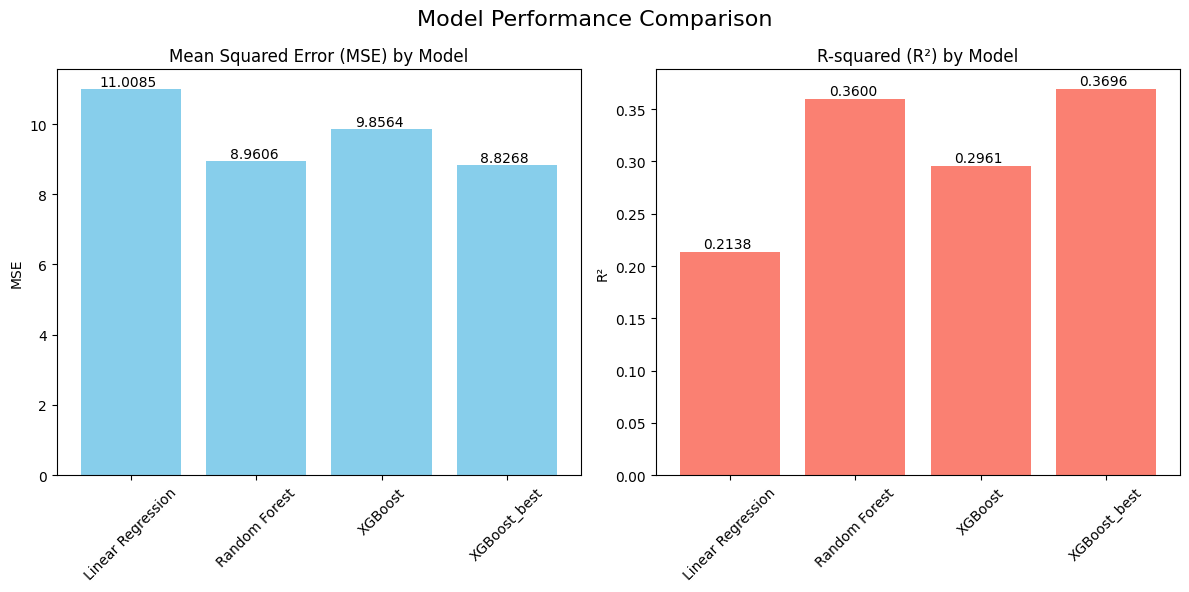

In [89]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'results_df'
# Set the figure size
plt.figure(figsize=(12, 6))

# Define a function to calculate y-axis offset for value placement
def autolabel(rects, ax):
    """
    Attach a text label above each bar in a bar chart.

    Args:
        rects (list): A list of bar rectangles.
        ax (matplotlib.axes._axes.Axes): The matplotlib Axes object.
    """
    for rect in rects:
        height = rect.get_height()
        # Add a small offset to avoid clipping with the bar
        ax.text(
            rect.get_x() + rect.get_width() / 2.1,
            height + 0.001,  # Adjust the 0.01 for better spacing
            f'{height:.4f}',
            ha='center',
            va='bottom'
        )

# Plotting MSE
plt.subplot(1, 2, 1)
rects1 = plt.bar(results_df['Model'], results_df['MSE'], color='skyblue')
plt.title('Mean Squared Error (MSE) by Model')
plt.ylabel('MSE')
plt.xticks(rotation=45)
autolabel(rects1, plt.gca())  # Call the function to add value labels

# Plotting R²
plt.subplot(1, 2, 2)
rects2 = plt.bar(results_df['Model'], results_df['R2'], color='salmon')
plt.title('R-squared (R²) by Model')
plt.ylabel('R²')
plt.xticks(rotation=45)
autolabel(rects2, plt.gca())  # Call the function to add value labels

plt.suptitle('Model Performance Comparison', fontsize=16)
# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Assuming X and Y are your features and target
# X_train, X_test, Y_train, Y_test should be defined earlier in your code
# For example:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to train
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('XGBoost', xgb.XGBRegressor(enable_categorical=True)))

results_ss = {
    'Model': [],
    'MSE': [],
    'R2': []
}

for name, model in models:
    if name == 'XGBoost':
        X_train_xgb = pd.get_dummies(X_train, columns=['land_use', 'land_cover'])
        X_test_xgb = pd.get_dummies(X_test, columns=['land_use', 'land_cover'])
        # Adjust the scaler to work with the new dummy-encoded data
        X_train_xgb_scaled = scaler.fit_transform(X_train_xgb)
        X_test_xgb_scaled = scaler.transform(X_test_xgb)
        model.fit(X_train_xgb_scaled, Y_train)
        predictions = model.predict(X_test_xgb_scaled)
    else:
        model.fit(X_train_scaled, Y_train)
        predictions = model.predict(X_test_scaled)

    mse = mean_squared_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)

    results_ss['Model'].append(name)
    results_ss['MSE'].append(mse)
    results_ss['R2'].append(r2)

# Convert the results to a DataFrame
results_scaled_df = pd.DataFrame(results_ss)

print(results_scaled_df)


               Model        MSE        R2
0  Linear Regression  11.008465  0.213794
1      Random Forest   8.901407  0.364277
2            XGBoost   9.995114  0.286166


In [90]:
import time
start_time = time.time()

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the model and parameters
xgb1 = XGBRegressor(enable_categorical=True)
parameters = {
    'objective': ['reg:squarederror'],
    'learning_rate': [0.0001, 0.001, 0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.1, 0.5, 1.0],
    'n_estimators': [100, 500]
}

# Set up GridSearchCV
xgb_grid2 = GridSearchCV(
    estimator=xgb1,
    param_grid=parameters,
    cv=3,
    n_jobs=-1,
    verbose=0
)

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Fit the model with grid search
xgb_grid2.fit(X_train_scaled, Y_train)

# Print the best score and parameters
print("Best Score:", xgb_grid2.best_score_)
print("Best Parameters:", xgb_grid2.best_params_)

best_model_ss = xgb_grid2.best_estimator_

predictions = best_model_ss.predict(X_test_scaled)
mse = mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print("MSE ", mse, "R2 ", r2)

#above should be positive eg instead of -cv_results.mean() is cv_results.mean()
print("--- %s seconds ---" % (time.time() - start_time))

Best Score: 0.2841642250106145
Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.1}
MSE  8.808515775123457 R2  0.37091091556212885
--- 1480.4973666667938 seconds ---


In [91]:
results_ss['Model'].append('XGBoost_best')
results_ss['MSE'].append(mse)
results_ss['R2'].append(r2)

results_scaled_df = pd.DataFrame(results_ss)

print(results_scaled_df)

               Model        MSE        R2
0  Linear Regression  11.008465  0.213794
1      Random Forest   8.901407  0.364277
2            XGBoost   9.995114  0.286166
3       XGBoost_best   8.808516  0.370911


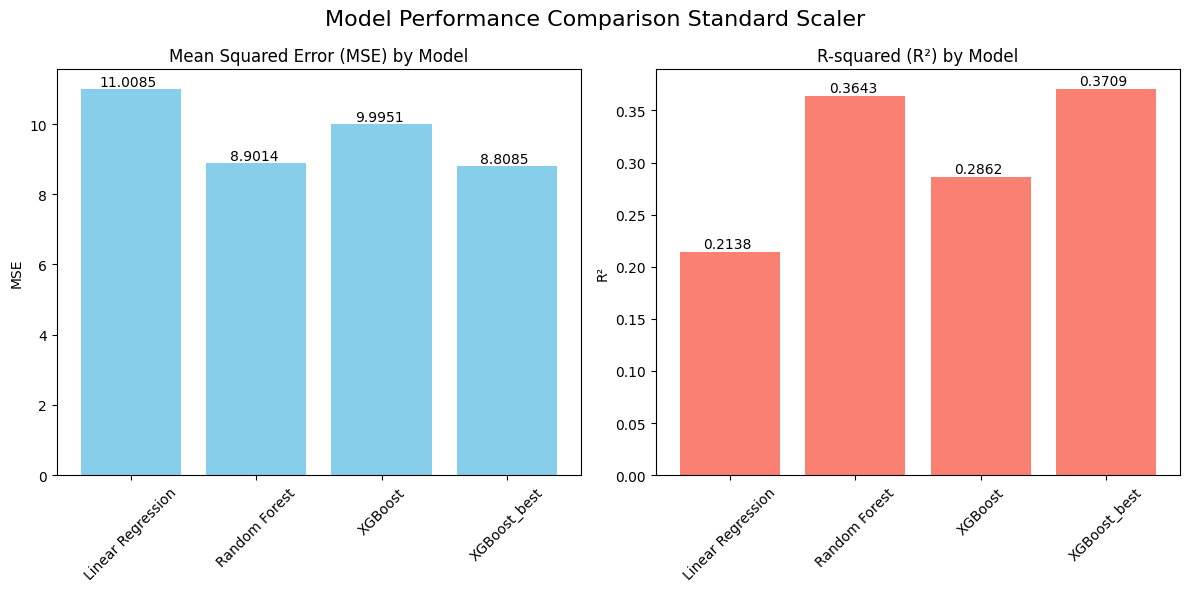

In [92]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'results_df'
# Set the figure size
plt.figure(figsize=(12, 6))

# Define a function to calculate y-axis offset for value placement
def autolabel(rects, ax):
    """
    Attach a text label above each bar in a bar chart.

    Args:
        rects (list): A list of bar rectangles.
        ax (matplotlib.axes._axes.Axes): The matplotlib Axes object.
    """
    for rect in rects:
        height = rect.get_height()
        # Add a small offset to avoid clipping with the bar
        ax.text(
            rect.get_x() + rect.get_width() / 2.1,
            height + 0.001,  # Adjust the 0.01 for better spacing
            f'{height:.4f}',
            ha='center',
            va='bottom'
        )

# Plotting MSE
plt.subplot(1, 2, 1)
rects1 = plt.bar(results_scaled_df['Model'], results_scaled_df['MSE'], color='skyblue')
plt.title('Mean Squared Error (MSE) by Model')
plt.ylabel('MSE')
plt.xticks(rotation=45)
autolabel(rects1, plt.gca())  # Call the function to add value labels

# Plotting R²
plt.subplot(1, 2, 2)
rects2 = plt.bar(results_scaled_df['Model'], results_scaled_df['R2'], color='salmon')
plt.title('R-squared (R²) by Model')
plt.ylabel('R²')
plt.xticks(rotation=45)
autolabel(rects2, plt.gca())  # Call the function to add value labels

plt.suptitle('Model Performance Comparison Standard Scaler', fontsize=16)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


#### Result Comparison between models

## Saving the model

In [ ]:
best_model = xgboost
joblib.dump(best_model, 'xgb_model.joblib')


best_model.save_model('xgb_model.json')